# CSS Lab: Networks

In [1]:
%pylab inline
import itertools
import json
import math
import urllib.request
import networkx as nx
import networkx as networkx
import networkx.algorithms as nxalg
import networkx.algorithms.community as nxcom
import networkx.readwrite as nxrw
import pandas as pd
import visJS2jupyter.visJS_module as vjs

Populating the interactive namespace from numpy and matplotlib


## 1. Build and visualize a network

This section loads network data from a file and explores its basic properties. 

In [55]:
# Helper functions

def load_sample_affiliation(filename="external/hamilton.csv"):
    B = nxrw.adjlist.read_adjlist(filename, delimiter="; ", comments="%")
    return B

def load_sample(filename="external/hamilton.csv", threshold=None):
    # Load the song-character affiliation network
    B = load_sample_affiliation()
    # Get list of songs from the file
    songs = set()
    with open(filename) as f:
        f.readline()
        for row in f:
            songs.add(row.split("; ")[0])
    # Deduce list of charactes
    characters = set(B.nodes()) - songs
    # Project the affiliation network onto the set of characters
    G = nxalg.bipartite.projection.weighted_projected_graph(B, characters)
    # Threshold
    if threshold is not None:
        for s, t, data in list(G.edges(data=True)):
            if data["weight"] < threshold:
                G.remove_edge(s,t)
    return G

def visualize_visjs(
        G, communities=None, colors=None, default_color="192,192,192",
        node_size_field="node_size", layout="spring", scale=500,
        title=""):
    # Get list of nodes and edges
    nodes = list(G.nodes())
    edges = list(G.edges())
    # Per-node properties
    nodes_dict = dict((n, {
        "id": n,
        "node_size_field": "node_size",
        "node_size": 5,
        }) for n in nodes)
    # Generate a layout for the nodes
    if layout == "circle":
        pos = nx.circular_layout(G, scale=scale)
    else:
        pos = nx.spring_layout(G, k=3/math.sqrt(len(nodes)), scale=scale)
    for n in nodes:
        nodes_dict[n]["x"] = pos[n][0],
        nodes_dict[n]["y"] = pos[n][1]
    # If we have communities, assign color based on community
    if colors is None:
        colors = [
            "0,255,0",
            "0,0,255",
            "0,255,255",
            "127,127,0",
            "255,0,0",
            "127,127,255"]
    if communities is not None:
        for i, com in enumerate(sorted(communities, key=lambda x: len(x), reverse=True)):
            for node in com:
                try:
                    nodes_dict[node]["color"] = "rgba({},1)".format(colors[i])
                    nodes_dict[node]["color_index"] = i
                except IndexError:
                    nodes_dict[node]["color"] = "rgba({},1)".format(default_color)
    # Map node labels to contiguous ids
    node_map = dict(zip(nodes,range(len(nodes))))
    # Determine edge colors
    edge_colors_idx = {}
    for source, target in edges:
        source_color = nodes_dict[source].get("color_index", None)
        target_color = nodes_dict[target].get("color_index", None)
        if source_color == target_color and source_color is not None:
            edge_colors_idx[(source, target)] = source_color
    edge_colors = dict(
        (e,colors[c])
        for e, c in edge_colors_idx.items() if c < len(colors))
    # Per-edge properties, use contiguous ids to identify nodes
    edges_dict = [{
        "source": node_map[source],
        "target": node_map[target],
        "title":'test',
        "color": "rgba({},0.25)".format(edge_colors.get((source,target), default_color))}
        for source, target in edges]
    # Convert nodes dict to node list
    nodes_list = [nodes_dict[n] for n in nodes]
    # Call visjs
    return vjs.visjs_network(
    nodes_list, edges_dict,
    node_size_multiplier=10.0,
    graph_id=hash(title))

### Loading the network

The next cell loads data from a file using the `networkx` library,
and displays a list of nodes in the network.
This example uses characters from the play _Hamilton_.

In [3]:
G = load_sample()
sorted(G.nodes())

['A. Burr',
 'A. Hamilton',
 'A. Schuyler',
 'C. Lee',
 'E. Schuyler',
 'G. Eaker',
 'G. Washington',
 'George III',
 'H. Mulligan',
 'J. Laurens',
 'J. Madison',
 'J. Reynolds',
 'Lafayette',
 'M. Reynolds',
 'P. Hamilton',
 'P. Schuyler',
 'S. Seabury',
 'T. Jefferson']

Now that you know the labels of the nodes, you can see which nodes are connected by an edge.
In this case, two nodes are connected by an edge if the corresponding characters have parts in the same song.
The next cell chooses a single node and prints a list of all the other nodes it's connected to.
These nodes are called its neighbors.

In [ ]:
sorted(G.neighbors('E. Schuyler'))

### Visualizing the network
In these visualizations, each circle represents a node.
Edges between two nodes are represented by drawing a line between them.

There are many ways to draw a network.
One simple way is to space all the nodes evenly around a circle.

In [ ]:
visualize_visjs(G, layout="circle", title="Circular Layout Example")

Another common way to visualize a network is using a "force-directed" layout.
In a force-directed layout, nodes push away from each other, but edges act like springs pulling them back together.
As a result, nodes with many neighbors in common are pulled closer to each other.

In [47]:
visualize_visjs(G, scale=1000)

What do the people in the center of the network have in common? What about the people around the edge?

What are some benefits and drawbacks of the circular layout versus the force-directed layout?

## 2. Centrality measures

One benefit of representing data as a network is that the patterns of connections between nodes can reveal useful information.
Many standard techniques for investigating the structure of networks have been developed.

One of the simplest questions to ask is: which nodes are most important?
But what does "important" mean exactly?
There are several common ways to measure importance, or _centrality_, of nodes in a nework.
This section examines several of the most popular.

While the _Hamilton_ network in the previous section is simple enough to be illustrative,
a historical data set better demonstrates how centrality measures can be applied to real-world networks.
This section uses historical data on affilations between organizers of the American Revolution,
taken from [Using Metadata to Find Paul Revere](https://kieranhealy.org/blog/archives/2013/06/09/using-metadata-to-find-paul-revere/).

In [5]:
# Helper functions

def load_sample_affiliation_url(
        url="https://raw.githubusercontent.com/kjhealy/revere/master/data/PaulRevereAppD.csv"):
    data = urllib.request.urlopen(url)
    df = pd.read_csv(data).set_index("Unnamed: 0")
    people = list(df.index)
    groups = list(df.columns)
    #
    B = nx.Graph()
    for column in df.columns:
        for row in df[df[column] == 1].index:
            B.add_edge(column, row)
    return people, groups, B

def load_sample_url(
        url="https://raw.githubusercontent.com/kjhealy/revere/master/data/PaulRevereAppD.csv",
        threshold=None):
    # Load the affiliation network
    people, groups, B = load_sample_affiliation_url(url)
    # Project the affiliation network onto the set of people
    G = nxalg.bipartite.projection.weighted_projected_graph(B, people)
    # Threshold
    if threshold is not None:
        for s, t, data in list(G.edges(data=True)):
            if data["weight"] < threshold:
                G.remove_edge(s,t)
    return G

# Standardize a vector to 0 mean and unit variance
def scale(v):
    return (v - v.mean()) / v.std()

# Return a data frame sorted by a node's centrality relative the mean of its centralities
def rel_centrality(df, measure):
    name = 'rel_{}'.format(measure)
    return pd.DataFrame({name: df[measure] / df['mean_centrality']})

The next cell begins by loading the data into a `networkx` graph. As is, an analysis of the data will reveal Paul Revere to be highly central by all measures [HEALEY2013] so to make the example more interesting, let's ask this: if Paul Revere had been on vacation, who might have notified the Massachusetts Provincial Congress of the impending attack in his place? To do so, we remove Paul Revere from the network. 

In [6]:
G = load_sample_url()
people, groups, B = load_sample_affiliation_url()
G.remove_node('Revere.Paul')

Before continuing, the next cell visualizes the network. Take a minute to examine the network and consider the following questions:
* Who might act as a bridge between different parts of the network?
* Who are the most well-connected?
* Who might play a role similar to Paul Revere?

In [48]:
visualize_visjs(G, scale=1500, title="American Revolution")

Now let's move on to examine the centralities. The next cell uses `networkx` to calculate node centralities and then stores them in a data frame. For each node we also calculate a mean centrality value.

In [8]:
df = pd.DataFrame({"id": G.nodes(), "label": G.nodes()}).set_index("id")
df['degree'] = pd.Series(nx.degree_centrality(G))
df['betweenness'] = pd.Series(nx.betweenness_centrality(G))
df['closeness'] = pd.Series(nx.closeness_centrality(G))
df['eigenvector'] = pd.Series(nx.eigenvector_centrality(G))

In [9]:
# Calculate mean of all centrality measures
df['mean_centrality'] = (
    scale(df['degree'])
    + scale(df['betweenness'])
    + scale(df['closeness'])
    + scale(df['eigenvector'])) / 4.0

### Degree

One very simple way to find important nodes is to count how many neighbors they have.
This measure is called the degree centrality.
This number is typically divided by the total number of other nodes in the network, so a value
of 0.82 means that a node is connected to 82% of the other nodes.
The next cell shows the nodes with the highest degree centralities.

Note that some of the people have the same degree. In fact, if two people have exactly the same set of neighbors,
all of their centrality scores will be the same.

In [17]:
df.sort_values('degree', ascending=False).head(5)

,label,degree,betweenness,closeness,eigenvector,mean_centrality
id,,,,,,
Chase.Thomas,Chase.Thomas,0.761905,0.041932,0.807692,0.120804,3.161785
Bass.Henry,Bass.Henry,0.761905,0.041932,0.807692,0.120804,3.161785
Barber.Nathaniel,Barber.Nathaniel,0.761905,0.036101,0.807692,0.121012,3.040089
Urann.Thomas,Urann.Thomas,0.753968,0.106664,0.802548,0.112889,4.438730
Proctor.Edward,Proctor.Edward,0.738095,0.029725,0.792453,0.120491,2.786450


Instead of searching for the highest degree centrality nodes, we can find nodes that have an unusually high degree centrality compared to its other centralities.

* How do the results below compare to those above?
* Why might someone have a high centrality of one type and a low centrality of another type?

In [18]:
rel_centrality(df, 'degree').sort_values('rel_degree', ascending=False).head()

,rel_degree
id,
Pulling.John,1.146036
Cheever.Ezekiel,1.146036
Parkman.Elias,1.146036
Winthrop.John,1.146036
Ruddock.Abiel,1.146036


### Betweenness

Rather than highly-connected nodes, you might want to find nodes that connect different parts of the network.
These types of nodes are sometimes called bridges, or brokers.
The betweenness centrality is based on finding the shortest path between nodes.
The nodes on that path play the role of bridges, connecting the endpoints.
So the betweenness is the fraction of all shortest paths in the network that pass through a given node.

In [19]:
df.sort_values('betweenness', ascending=False).head(5)

,label,degree,betweenness,closeness,eigenvector,mean_centrality
id,,,,,,
Urann.Thomas,Urann.Thomas,0.753968,0.106664,0.802548,0.112889,4.438730
Warren.Joseph,Warren.Joseph,0.662698,0.102033,0.747774,0.046124,3.496944
Peck.Samuel,Peck.Samuel,0.575397,0.065971,0.701950,0.098779,2.687323
Bass.Henry,Bass.Henry,0.761905,0.041932,0.807692,0.120804,3.161785
Chase.Thomas,Chase.Thomas,0.761905,0.041932,0.807692,0.120804,3.161785


In [20]:
rel_centrality(df, 'betweenness').sort_values('rel_betweenness', ascending=False).head()

,rel_betweenness
id,
Barrett.Samuel,0.034610
Warren.Joseph,0.029178
Peck.Samuel,0.024549
Urann.Thomas,0.024030
Cooper.Samuel,0.019168


### Closeness

A nodes might also be considered important if it is close to many other nodes.
In other words, if the paths connecting it to other nodes are all very short.
This measure is called closeness centrality.

In [21]:
df.sort_values('closeness', ascending=False).head(5)

,label,degree,betweenness,closeness,eigenvector,mean_centrality
id,,,,,,
Chase.Thomas,Chase.Thomas,0.761905,0.041932,0.807692,0.120804,3.161785
Bass.Henry,Bass.Henry,0.761905,0.041932,0.807692,0.120804,3.161785
Barber.Nathaniel,Barber.Nathaniel,0.761905,0.036101,0.807692,0.121012,3.040089
Urann.Thomas,Urann.Thomas,0.753968,0.106664,0.802548,0.112889,4.438730
Proctor.Edward,Proctor.Edward,0.738095,0.029725,0.792453,0.120491,2.786450


In [22]:
rel_centrality(df, 'closeness').sort_values('rel_closeness', ascending=False).head()

,rel_closeness
id,
Pulling.John,1.762048
Cheever.Ezekiel,1.762048
Parkman.Elias,1.762048
Winthrop.John,1.762048
Ruddock.Abiel,1.762048


### Eigenvector

The last centrality measure covered in this section measures not just how well-connected a node is, but how well-connected its neighbors are as well.
This measure is the eigenvector centrality.
The PageRank algorithm used by Google to find high quality websites is an extension of this algorithm.

In [23]:
df.sort_values('eigenvector', ascending=False).head(5)

,label,degree,betweenness,closeness,eigenvector,mean_centrality
id,,,,,,
Barber.Nathaniel,Barber.Nathaniel,0.761905,0.036101,0.807692,0.121012,3.040089
Bass.Henry,Bass.Henry,0.761905,0.041932,0.807692,0.120804,3.161785
Chase.Thomas,Chase.Thomas,0.761905,0.041932,0.807692,0.120804,3.161785
Condy.JamesFoster,Condy.JamesFoster,0.738095,0.029725,0.792453,0.120491,2.786450
Proctor.Edward,Proctor.Edward,0.738095,0.029725,0.792453,0.120491,2.786450


In [24]:
rel_centrality(df, 'eigenvector').sort_values('rel_eigenvector', ascending=False).head(5)

,rel_eigenvector
id,
Collier.Gershom,0.190084
Purkitt.Henry,0.190084
Ingersoll.Daniel,0.190084
Russell.John,0.190084
Fenno.Samuel,0.190084


### Interpreting centrality measures

Looking over the above centrality results, consider the questions below. It may be helpful to see the list of organizations a person belonged to, which can be done in the next cell.

* Did any of the measures show the same people as being most central?
* Members of the Tea Party (e.g. `Collier.Gershom`) have a high degree centrality, but low betweenness centrality. What does that tell you about the Tea Party as compared to other groups?
* What would a group with _high_ betweenness and _low_ degree centrality look like?
* Of the important people you identified from the visualization, were any in the lists of high-centrality individuals? If so, which types of centrality.


In [31]:
list(nx.neighbors(B, "Collier.Gershom"))

['TeaParty']

### Comparing centrality measures

The following plot shows how different centrality measures are related to each other (in this network).
Each graph compares two centrality measures corresponding to its row and column.
In each graph, each point represents a single node in the network.

Points are drawn with transparency so overlapping points are darker.
If a group of people have the same centralities,
possibly because they have the same set of neighbors,
they appear as a single dark spot.

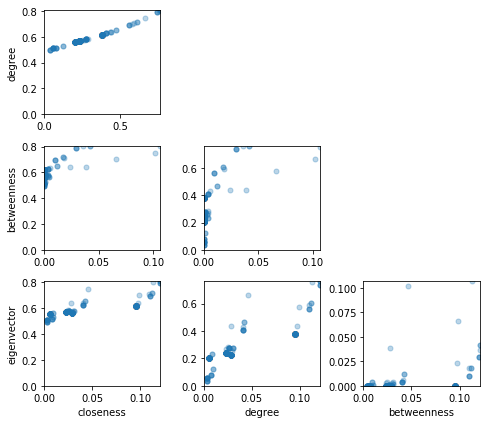

In [28]:
# Store column names in array to keep order consistent
measures = ["degree", "betweenness", "eigenvector", "closeness"]
plt.figure(figsize=(7,6))
# Loop through rows and columns
# Even though we have 4 measures, we only need 3x3 to compare all
for row in range(3):
    for col in range(3):
        # Each row column pair only needs to be plotted once
        if row >= col:
            # The longest row should correspond to the measure that
            # does not appear on a column.
            x, y = df[measures[row]], df[measures[(col-1) % 4]]
            plt.subplot(3,3,1 + row*3 + col)
            plt.plot(x, y, '.', alpha=0.3, markersize=10)
            plt.xlim([0, x.max()]); plt.ylim([0, y.max()])
        if row == 2:
            plt.xlabel(measures[(col - 1) % 4])
        if col == 0:
            plt.ylabel(measures[row])
plt.tight_layout()

## Community structure

What if you didn't know the groups people belonged to and wanted to find them from the network? This is the problem of community detection. There are many ways to find communities. The following cells find and visualize communities using a method that maximizes _modularity_ [CNM2004]. Networks with high modularity have a high number of edges between nodes in the same community and a low number of edges across communities. One benefit of this method is that it determines the best number of communities. In the visualization below, different communities are shown in different colors.

In [51]:
communities = list(nxcom.greedy_modularity_communities(G))

In [56]:
visualize_visjs(G, communities=communities, scale=1500, title="Community Detection Example")

### Interpreting communites
The next cell will help you see lists of organizations each person belongs to.

* Do the communities make sense?
* Can you connect particular communities to actual groups (or groups or groups)?
* Why would two groups belong to the same community when two others don't?

In [58]:
list(nx.neighbors(B, "Church.Benjamin"))

['NorthCaucus', 'LongRoomClub', 'BostonCommittee', 'LondonEnemies']

### Shortest paths and diameter

In [107]:
path_lengths = list(itertools.chain(*[
        [length for length in targets.values() if length > 0]
    for source, targets in list(nxalg.shortest_path_length(G))]))


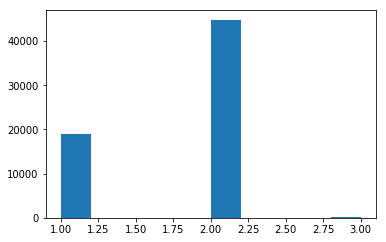

In [110]:
plt.hist(path_lengths)
plt.tight_layout(3)

## References

[HEALEY2013] Healy, K. 2013. "Using Metadata to Find Paul Revere." https://kieranhealy.org/blog/archives/2013/06/09/using-metadata-to-find-paul-revere/

[CNM2004] Clauset, A., Newman, M. E., & Moore, C. (2004). Finding community structure in very large networks. Physical review E, 70(6).

[RLWGBF2017] Rosenthal, S. B., Len, J., Webster, M., Gary, A., Birmingham, A., & Fisch, K. M. (2017). Interactive network visualization in Jupyter notebooks: visJS2jupyter. Bioinformatics.

[BS2016] A. Beveridge and J. Shan, "Network of Thrones," Math Horizons Magazine , Vol. 23, No. 4 (2016), pp. 18-22

## SCRATCH SPACE BELOW HERE

## Build and visualize a network

In [12]:
def load_lost_circles_json(in_file):
    with open(in_file) as f:
        raw = json.load(f)
    id_to_name = dict((i, datum["name"]) for i, datum in enumerate(raw['nodes']))
    edges = [(datum["source"], datum["target"]) for datum in raw['links']]
    return id_to_name, edges

In [13]:
in_file = "external/LostCircles/sample.json"
id_to_name, edges = load_lost_circles_json(in_file)

In [14]:
FB = nx.Graph()
FB.add_edges_from(edges)
giant_component = max(list(nxalg.connected_components(FB)), key=len)
for node in (set(FB.nodes()) - set(giant_component)):
    FB.remove_node(node)

## Find communities

In [15]:
communities = []
for i, com in enumerate(nxcom.greedy_modularity_communities(FB)):
    print("Found {}:".format(i))
    most_recent = com
    communities.append(com)

Found 0:
Found 1:
Found 2:
Found 3:
Found 4:
Found 5:
Found 6:
Found 7:
Found 8:
Found 9:
Found 10:


In [16]:
visualize_visjs(G, communities, title="fb", scale=4000)

KeyError: 0

In [ ]:
%pylab inline
import json
import math
import urllib.request
import networkx as nx
import networkx as networkx
import networkx.algorithms as nxalg
import networkx.algorithms.community as nxcom
import networkx.readwrite as nxrw
import pandas as pd
import visJS2jupyter.visJS_module as vjs

In [ ]:
k = nx.karate_club_graph()

In [ ]:
john_a = frozenset([8,9,14,15,18,20,22,23,24,25,26,27,28,29,30,31,32,33])
mr_hi = frozenset([0,1,2,3,4,5,6,7,10,11,12,13,16,17,19,21])


In [ ]:
nx.community.is_partition(k, {john_a, mr_hi})

In [ ]:
c = nx.community.greedy_modularity_communities(k)

In [ ]:
x = list(c)
x

In [ ]:
edges = list(k.edges())

In [ ]:
edges